# COGS 108 - Final Project

## Introduction & Background

Every day drivers across the United States are stopped by police officers and issued traffic tickets. Often, drivers get pulled over for a few common reasons, such as speeding, distracted driving, equipment violations, tailgating and improper lane changes, etc. However, there might be other factors such as race, gender, and age, as well as time of day and location, that could impact both whether a driver is pulled over for a traffic violation, as well as the severity of the result.

As for background information, we did some research on the issue of police vehicle stops to further making predictions for this project. One of the articles we found indicated that a larger portion of black and hispanic drivers were being pulled over as opposed to white drivers. Additionally, a similar analysis conducted on traffic stop data showed that black and hispanic drivers were “more likely than white drivers to be searched following a traffic stop”. Plus, based on our own experiences, as well as those of others frequently heard about in the media, we came to the prediction that minority groups may possible be targeted with more severe or frequent citations. As for gender, there are existing stereotypes that women normally have a harder time on the road compared to men. Plus, gender ideologies that have been established lead us to the prediction that women tend to get pulled over more often. Looking into this data would help clarify these stereotypes and ideologies.

As we all know police officers can’t randomly pull drivers over and give tickets without having probable cause, like speeding or equipment violations. However, there might be cases where you feel as though you are not at fault but afraid to fight back against them because police officers have higher authority. In fact, we ourselves had experienced being pulled over and getting tickets for unreasonable situations. We believe this information may be important for us and others to figure out a way to back up ourselves under circumstances that we don’t feel at fault. In any case, whether these variables have some correlation or relationship with traffic violations would be both interesting and useful to know.

### Group Members:
- A11463602
- A14255637
- A13167547
- A13633912

### Research Question
What is the relationship between race/gender/resident status and traffic violation frequency in San Diego?

### Hypothesis
We predict that women drivers tend to get pulled over by police officers more often than male drivers. As for race, we predict that minority groups and nonwhite races also tend to get stopped more frequently than others. After skimming through the dataset, we also predict that San Diego residents tend to get stopped in a longer time frame and frequently get tickets more than non-residents. 

### Dataset Information
- Police Vehicle Stops in 2016
- https://data.sandiego.gov/datasets/police-vehicle-stops/
- 103051 entries in raw dataset

The websites provides data for vehicle stops in separate datasets per year, and also provides a separate dataset with the results of each traffic stop. The vehicle stop dataset contains information such as the race, gender, and age of the person stopped, as well as the stop date, time, and location. The separate dataset with results has information on whether the stop resulted in a warning, a ticket, etc. We can analyze these independently or combine them to see any relationships between the profile of the person stopped and the result of the stop.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind

In [2]:
csvfile = 'vehicle_stops_2016_datasd.csv'
initial_df = pd.read_csv(csvfile)

In [3]:
#initial_df

## Data Cleaning & Preprocessing

To clean our data, we start off by removing rows with traffic stop information for equipment violations, as we are currently only looking at moving violation data. We also remove any rows where there is no recorded age data. 
We removed the 'obtained_consent', 'contraband_found', and 'property_seized' columns as there was not enough traffic stops where this was recoreded to perform a meaningful analysis. We also removed the 'service_area' column as it was not relevant to our analysis, as well as the 'stop_id' and 'stop_cause' columns as they were reduntant. We then dropped all rows with NaN data as well as rows containing an invalid entry in the 'timestamp' column.

In [4]:
df = initial_df[initial_df.stop_cause == 'Moving Violation']
df = df[df.subject_age != 'No Age']
del df['obtained_consent']
del df['contraband_found']
del df['property_seized']
del df['service_area']
del df['stop_id']
del df['stop_cause']
df.dropna(subset=['timestamp'])
df.dropna(inplace=True)
df = df[['timestamp', 'stop_date', 'stop_time', 'subject_race', 'subject_sex', 'subject_age', 'sd_resident', 'arrested', 'searched']]

In [5]:
df

,timestamp,stop_date,stop_time,subject_race,subject_sex,subject_age,sd_resident,arrested,searched
1,2016-01-01 00:10:00,2016-01-01,0:10,B,M,25,N,N,N
3,2016-01-01 00:16:00,2016-01-01,0:16,W,F,29,N,N,N
4,2016-01-01 00:30:00,2016-01-01,0:30,W,M,52,N,N,N
5,2016-01-01 00:30:00,2016-01-01,0:30,H,M,24,Y,N,N
6,2016-01-01 00:35:00,2016-01-01,0:35,O,M,20,Y,N,N
7,2016-01-01 00:45:00,2016-01-01,0:45,H,M,50,Y,N,N
8,2016-01-01 01:03:00,2016-01-01,1:03,H,F,25,Y,N,Y
9,2016-01-01 01:10:00,2016-01-01,1:10,W,F,23,Y,N,N
10,2016-01-01 01:20:00,2016-01-01,1:20,O,M,54,Y,N,N
11,2016-01-01 01:39:00,2016-01-01,1:39,W,F,53,Y,N,N


## Data Visualization

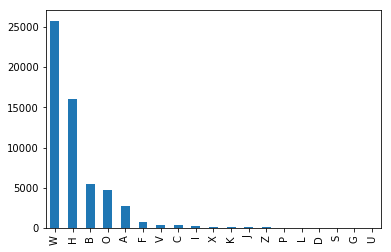

In [6]:
df['subject_race'].value_counts().plot(kind='bar')

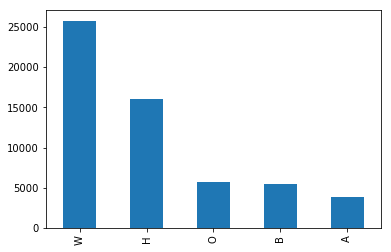

In [7]:
df_r = df.copy()
df_r.subject_race = df.subject_race.replace({"C" : "A", 
                                             "D" : "A",
                                             "F" : "O", 
                                             "G" : "O",
                                             "I" : "A",
                                             "J" : "A",
                                             "K" : "A",
                                             "L" : "O",
                                             "P" : "O",
                                             "S" : "O",
                                             "U" : "O",
                                             "V" : "A",
                                             "Z" : "A",
                                             "X" : "O",})
df_r['subject_race'].value_counts().plot(kind='bar')

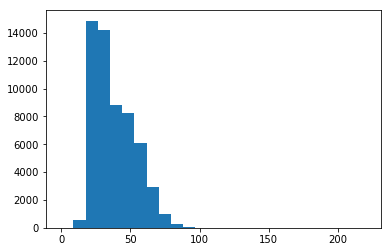

In [8]:
df_a = df.copy()
df_a.subject_age = pd.to_numeric(df_a.subject_age, errors='coerce')
plt.hist(df_a['subject_age'], 25)
f1 = plt.gcf()

In [9]:
mean = df_a['subject_age'].mean()
std3 = 3 * df_a['subject_age'].std()
std_max = mean + std3
std_min = mean - std3
df_a = df_a[df_a['subject_age'] > std_min]
df_a = df_a[df_a['subject_age'] < std_max]
df_a = df_a[df_a['subject_age'] > 10]

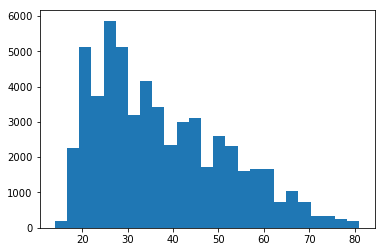

In [10]:
df_a.subject_age = pd.to_numeric(df_a.subject_age, errors='coerce')
plt.hist(df_a['subject_age'], 25)
f1 = plt.gcf()

## Data Analysis & Results

## Conclusions & Discussion